# 线性回归 + 基础优化算法 

## 1. 线性回归

<b>房价预测</b>

简化模型: <br>
&emsp;&emsp;假设1: 影响房价的关键因素是卧室个数, 卫生间个数和居住面积, 记为$ x_1、x_2、 x_3 $<br>
&emsp;&emsp;假设2: 成交价是关键因素的加权和$ y = w_1x_1 + w_2x_2 + w_3x_3 +b $<br>
权重和偏差的实际值在后面决定<br>

<b>线性模型</b><br>
&emsp;&emsp;&emsp;y = <<b>w</b>, <b>x</b>> + b

&emsp;&emsp;&emsp;线性神经网络可以看做是单层的神经网络

&emsp;&emsp;&emsp;神经网络源自神经科学

<b>衡量预估的质量</b>
* 比较真实值和预估值的差距, 例如房屋售价和估价
* 假设y是真实值, $\hat{y}$ 是估计值, 我们可以比较 $\ell (y, \hat{y}) = \frac{1}{2}(y - \hat{y})^2 $, 这个叫做平方损失

<b>训练数据</b>
* 手机过去6个月卖的房子
* 这个被称为训练数据
* 通常越多越好
* 假设我们又n个样本

<b>参数学习</b><br>
* 训练损失<br>
&emsp;&emsp;$\ell(\vec{X},\vec{y}, \vec{w},b) = \frac{1}{2n}\sum_{i=1}^{n}(y_i - <\vec{x_i}\vec{w}-b>)^2 = \frac{1}{2n}\left \| \vec{y} - \vec{X}\vec{w} - b\right \|^2$
* 最小化损失来学习参数


<b>显式解(解析解)</b></br>

&emsp;&emsp;因为该损失函数是凸函数, 所以最优解可得到解析解

<b>总结</b></br>
* 线性回归是对n维输入的加权, 外加偏差
* 使用平方损失来衡量预测值和真实值的差异
* 线性回归可以有解析解
* 线性回归可以看做是单层的神经网络


## 2.基础优化算法

### 2.1 梯度下降

> 小批量随机梯度下降是深度学习默认的求解算法
* 对整个训练集上算梯度太贵
    * 一个神经网络模型可能需要数分钟至数小时
* 我们可以随机采样b个样本$i_1, i_2, ......, i_b$来近似损失

* 批量样本太大, 可能会造成计算浪费, 例如所有的样本都是相同的(2024-11-01 日补充)

## 3.线性回归的从零开始实现

In [1]:
import random
import torch
import matplotlib.pyplot as plt

from d2l.torch import d2l

根据带有噪声的线性模型构造一个人造数据集

In [2]:
def synthetic_data(w, b, num_examples):
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))  # 生成num_examples个样本，每个样本有len(w)个特征
    y = torch.matmul(X, w) + b      # y = Xw + b
    y += torch.normal(0, 0.01, y.shape)     # 添加噪声
    
    return X, y

true_w = torch.tensor([2, -3.4])    # 真实的w
true_b = 4.2   # 真实的b
features, labels = synthetic_data(true_w, true_b, 1000)

In [3]:
features.shape

torch.Size([1000, 2])

In [4]:
print('features:', features[0], '\nlabel:', labels[0])  # 打印第一个样本

features: tensor([-0.4633, -0.8930]) 
label: tensor(6.3073)


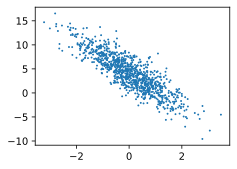

In [5]:
d2l.set_figsize()
d2l.plt.scatter(d2l.numpy(features[:, 1]), d2l.numpy(labels), 1)
d2l.plt.show()

In [6]:
# x1 = features[:, -1]
# y = labels
# plt.scatter(x1, y)

定义一个data_iter函数, 该函数接收批量大小、特征矩阵和标签向量作为输入, 生成大小为batch_size的小批量

In [9]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)    # 样本数
    indices = list(range(num_examples))   
    # 样本是随机读取, 没有特定的顺序
    random.shuffle(indices)     # 
    # print(indices) 
    # # 打印indices的列表大小
    # print(len(indices))
    for i in range(0, num_examples, batch_size):
        j = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[j], labels[j]    

In [10]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.5696, -1.7377],
        [ 0.6883, -0.1830],
        [-0.1100, -0.4331],
        [ 0.9754,  0.2469],
        [ 1.3568, -0.9464],
        [-0.7356, -1.1937],
        [ 0.6278,  1.1979],
        [-0.0159,  0.4109],
        [-1.3245, -1.2181],
        [ 0.1385, -1.2476]]) 
 tensor([ 6.9698,  6.1696,  5.4371,  5.3211, 10.1232,  6.7874,  1.3865,  2.7763,
         5.6817,  8.7051])


In [7]:
# 定义初始化模型参数
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)  # 初始化权重
b = torch.zeros(1, requires_grad=True) # 初始化偏置
w, b

(tensor([[ 0.0046],
         [-0.0062]], requires_grad=True),
 tensor([0.], requires_grad=True))

In [6]:
# 定义模型
def linreg(X, w, b):
    """线性回归模型"""
    return X@w + b

In [11]:
# 定义损失函数
def squqred_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

In [12]:
# 定义优化算法
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

> 训练过程

In [15]:
lr = 0.01   # 学习率
num_epochs = 10     # epochs 次数
net = linreg    # 网络结构
loss = squqred_loss     # 损失函数
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)   # 计算损失
        l.sum().backward()  # 反向传播求导
        sgd([w, b], lr, batch_size) # 梯度下降
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000049
epoch 2, loss 0.000049
epoch 3, loss 0.000049
epoch 4, loss 0.000049
epoch 5, loss 0.000049
epoch 6, loss 0.000049
epoch 7, loss 0.000049
epoch 8, loss 0.000049
epoch 9, loss 0.000049
epoch 10, loss 0.000049


比较真实参数和训练后的参数, 评估训练的成功程度

In [14]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f"b的估计误差: {true_b - b}")

w的估计误差: tensor([ 0.0005, -0.0011], grad_fn=<SubBackward0>)
b的估计误差: tensor([-0.0006], grad_fn=<RsubBackward1>)


### 自行实现

In [16]:
import random
from types import SimpleNamespace

import numpy as np
import torch
import matplotlib.pyplot as plt

#### 生成数据

In [17]:
# 生成数据
def make_data(W, b, Xmin, Xmax, num_examples):
    """生成数据集"""
    X = []
    for xmin, xmax in zip(Xmin, Xmax):
        x = np.random.random(num_examples) * (xmax - xmin) + xmin
        # x.sort()
        # print(x)
        X.append(x)
    X = torch.Tensor(X).T
    y = X@W + b 
    y += torch.normal(0, 0.01, y.shape)

    return X, y

In [18]:
my_true_W= torch.Tensor([1.2, 1.6])
my_true_b = torch.Tensor([3.4])
Xmin = [0, 0]
Xmax = [1, 1]
my_x, my_y = make_data(my_true_W, my_true_b, Xmin, Xmax, 1000)

/tmp/ipykernel_82972/775074723.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  X = torch.Tensor(X).T


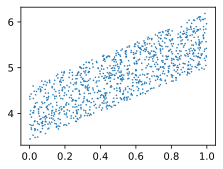

In [19]:
plt.scatter(my_x[:, 1], my_y, s=0.4)
plt.show()

#### 分割数据

In [20]:
def data_split(X, y, train_prop=0.75):
    """
    分割训练集和测试集
    """
    num_examples = len(y)
    indexs = np.arange(num_examples)
    num_elements = int(len(indexs) * train_prop)
    train_indexs = np.random.choice(indexs, num_elements, replace=False)
    test_indexs = indexs[~np.isin(indexs, train_indexs)]
    Data = SimpleNamespace()
    Data.TestX =  X[test_indexs]
    Data.TestY = y[test_indexs]
    Data.TrainX = X[train_indexs]
    Data.TrainY = y[train_indexs] 

    return Data

#### 定义网络结构

In [21]:
def net(X, W, b):
    return X@W + b

#### 定义损失函数

In [22]:
def loss_mse(y, y_hat):
    return ((y - y_hat.reshape(y.shape))**2) / 2

#### 批量化获取数据

In [22]:
def data_iter(X, y, batch_size=10):
    num_examples = len(X)    # 样本数
    indices = list(range(num_examples))   
    # 样本是随机读取, 没有特定的顺序
    random.shuffle(indices)     # 
    # print(indices) 
    # # 打印indices的列表大小
    # print(len(indices))
    for i in range(0, num_examples, batch_size):
        j = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield X[j], y[j]   

#### 定义优化函数

In [ ]:
def sgd(params, lr, batch_size):
    """
    :params: 参数
    :lr:学习率
    :batch_size: 批量大小
    """
    for param in params:
        with torch.no_grad():
            param -= lr * param.grad / batch_size   # 除以batch_size,每次的批量大小
            param.grad.zero_()  # 梯度置零
    

#### 定义初始化模型参数

In [24]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)  # 初始化权重
b = torch.zeros(1, requires_grad=True) # 初始化偏置
w, b

(tensor([[-0.0081],
         [ 0.0099]], requires_grad=True),
 tensor([0.], requires_grad=True))

In [25]:
my_true_W= torch.Tensor([2.2, 2.3])
my_true_b = torch.Tensor([3.4])
Xmin = [0, 0]
Xmax = [10, 10]
myX, myY = make_data(my_true_W, my_true_b, Xmin, Xmax, 1000)

#### 训练模型

In [26]:
loss = loss_mse     # 损失函数选择
batch_size = 10  # 批量大小
lr = 0.01   # 学习率
train_prop = 0.75   # 训练集百分比占比
num_epochs = 50   # 循环训练次数

In [27]:
Data = data_split(myX, myY)     # 分割训练集和测试集

In [28]:
# X, Y = Data.TrainX, Data.TrainY   # 训练集
# X, Y = synthetic_data(my_true_W, my_true_b, 1000)
# X, Y = myX, myY
X, Y =  Data.TrainX, Data.TrainY   # 训练集
X.shape, Y.shape

(torch.Size([750, 2]), torch.Size([750]))

In [29]:
for epoch in range(num_epochs):
    for x, y in data_iter(X, Y, batch_size):
        y_hat = net(x, w, b)    # 向前传播
        l = loss(y, y_hat)  # 计算损失
        l.sum().backward()    # 向后计算梯度
        sgd([w, b], lr, batch_size) # 随机梯度下降
    with torch.no_grad():
        L = loss(Y, net(X, w, b))
        print(f"epoch {epoch}: LOSS={L.mean():.2f}")

epoch 0: LOSS=0.51
epoch 1: LOSS=0.41
epoch 2: LOSS=0.34
epoch 3: LOSS=0.30
epoch 4: LOSS=0.23
epoch 5: LOSS=0.19
epoch 6: LOSS=0.16
epoch 7: LOSS=0.13
epoch 8: LOSS=0.11
epoch 9: LOSS=0.09
epoch 10: LOSS=0.09
epoch 11: LOSS=0.06
epoch 12: LOSS=0.05
epoch 13: LOSS=0.04
epoch 14: LOSS=0.04
epoch 15: LOSS=0.03
epoch 16: LOSS=0.02
epoch 17: LOSS=0.02
epoch 18: LOSS=0.02
epoch 19: LOSS=0.01
epoch 20: LOSS=0.01
epoch 21: LOSS=0.01
epoch 22: LOSS=0.01
epoch 23: LOSS=0.01
epoch 24: LOSS=0.00
epoch 25: LOSS=0.00
epoch 26: LOSS=0.00
epoch 27: LOSS=0.00
epoch 28: LOSS=0.00
epoch 29: LOSS=0.00
epoch 30: LOSS=0.00
epoch 31: LOSS=0.00
epoch 32: LOSS=0.00
epoch 33: LOSS=0.00
epoch 34: LOSS=0.00
epoch 35: LOSS=0.00
epoch 36: LOSS=0.00
epoch 37: LOSS=0.00
epoch 38: LOSS=0.00
epoch 39: LOSS=0.00
epoch 40: LOSS=0.00
epoch 41: LOSS=0.00
epoch 42: LOSS=0.00
epoch 43: LOSS=0.00
epoch 44: LOSS=0.00
epoch 45: LOSS=0.00
epoch 46: LOSS=0.00
epoch 47: LOSS=0.00
epoch 48: LOSS=0.00
epoch 49: LOSS=0.00


In [30]:
w, b

(tensor([[2.2024],
         [2.3024]], requires_grad=True),
 tensor([3.3763], requires_grad=True))